In [1]:
!git clone https://github.com/pranavmp-10-000/FontDetection/

fatal: destination path 'FontDetection' already exists and is not an empty directory.


In [2]:
!python3 /content/FontDetection/Data\ Generation.py

No of Links: 10
Traceback (most recent call last):
  File "/content/FontDetection/Data Generation.py", line 131, in <module>
    get_fonts(font_links,parent_dir)
  File "/content/FontDetection/Data Generation.py", line 61, in get_fonts
    os.makedirs(zip_save_directory)
  File "/usr/lib/python3.7/os.py", line 223, in makedirs
    mkdir(name, mode)
FileExistsError: [Errno 17] File exists: '/content/FontsFolder/Temp'


In [5]:
import os
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw
from PIL import Image
from PIL import ImageDraw
import glob

In [6]:
import numpy as np
import tensorflow as tf

In [7]:
#import wandb
import tensorflow as tf



In [9]:
font_links = ['https://fonts.google.com/specimen/Oswald',
                  'https://fonts.google.com/specimen/Roboto',
                  'https://fonts.google.com/specimen/Open+Sans',
                  'https://fonts.google.com/specimen/Ubuntu',
                  'https://fonts.google.com/specimen/PT+Serif',
                  'https://fonts.google.com/specimen/Dancing+Script',
                  'https://fonts.google.com/specimen/Fredoka+One',
                  'https://fonts.google.com/specimen/Arimo',
                  'https://fonts.google.com/specimen/Noto+Sans',
                  'https://fonts.google.com/specimen/Patua+One']

In [10]:
parent_dir = os.getcwd()
parent_dir

'/content'

# Plotting Fonts

In [11]:
fontsN = len(font_links)
if fontsN % 2 == 0:
    N_Rows = fontsN//2
    N_Columns = N_Rows
else:
    N_Rows = fontsN//2
    N_Columns = N_Rows + 1
font_sizes = [12,14,16,18,20,24,26,28,32,36,42]
maxFontSize = font_sizes[-1]
image_size = (2**(int(np.log2(maxFontSize))+3), 2**(int(np.log2(maxFontSize))+3))
image_size

(256, 256)

In [12]:
def draw_image(font_path, image_size):
        image = Image.new("RGB", image_size, (255, 255, 255))
        draw = ImageDraw.Draw(image)
        font_size = font_sizes[np.random.randint(0,len(font_sizes))]
        # use a truetype font
        font = ImageFont.truetype(font_path, font_size)
        fw,fh = font.getsize("Hello World!")
        H, W = image_size
        draw.text((W/2-fw/2, H/2-fh),
                "Hello World!", font=font, fill=(0, 0, 0))
        return image

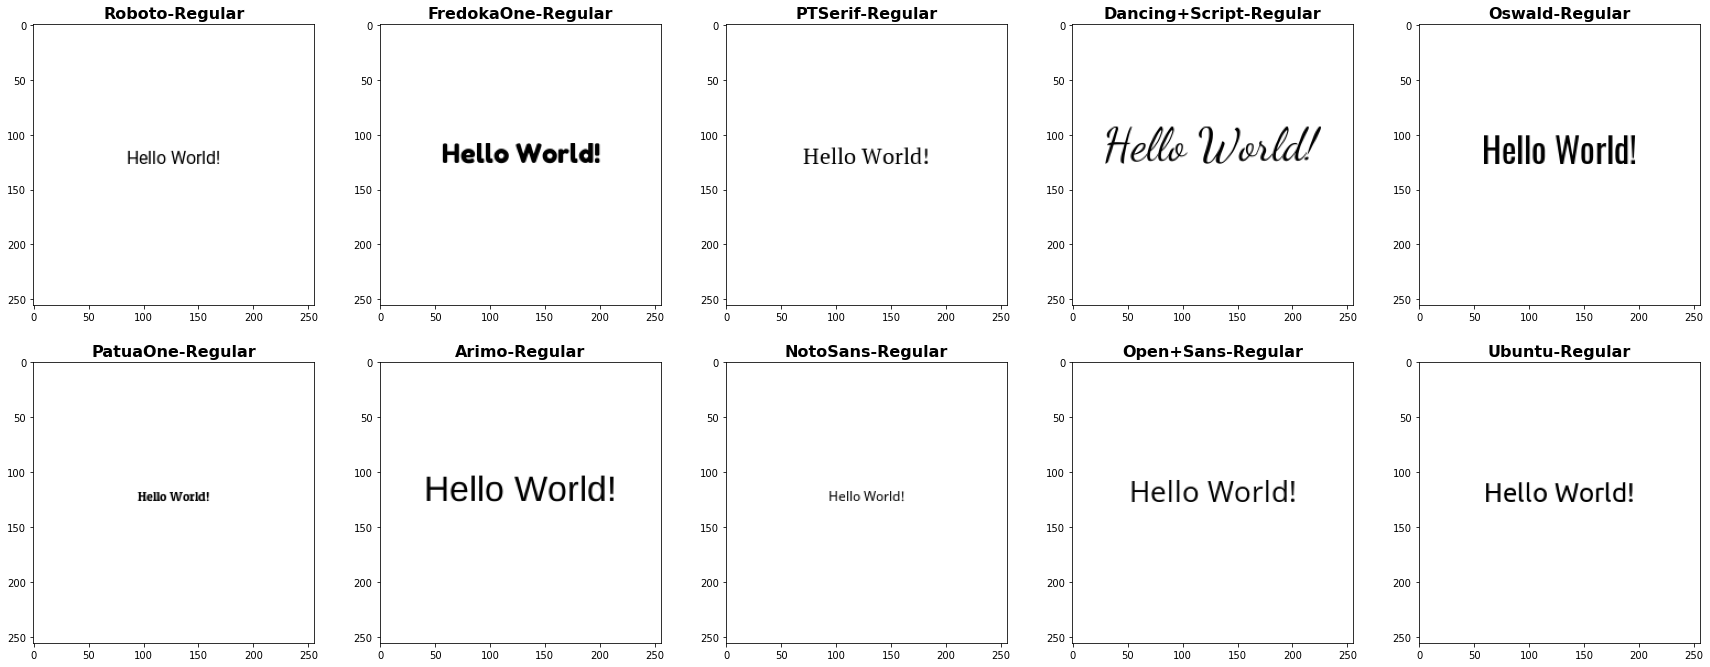

In [13]:
fonts_folder = os.path.join(parent_dir, 'FontsFolder')
pltIndex = 1
fig = plt.figure(figsize=(30, 30))
for i in glob.glob(fonts_folder+'/*.ttf'):
    plt.subplot(N_Rows, N_Columns, pltIndex)
    image = draw_image(i, image_size)
    plt.imshow(image)
    font_name = i.split('/')[-1].split('.')[0]
    plt.title(font_name, fontdict={'fontsize': 16, 'fontweight': 'bold', })
    pltIndex += 1

# Image Generation

In [14]:
!rm -r /content/ImagesDir

In [15]:
images_path = os.path.join(parent_dir,'ImagesDir')
if 'ImagesDir' not in os.listdir(parent_dir):
  os.makedirs(images_path)  

In [16]:
def gen_imgs(image_size,font_image_folder,N=50):
  for j in range(N):
    image = draw_image(i, image_size)
    image = image.resize((image_size[0]//4,image_size[1]//4))
    image.save(os.path.join(font_image_folder,'img'+str(j)+'.jpg'))

In [17]:
for i in glob.glob(fonts_folder+'/*.ttf'):
  font_name = i.split('/')[-1].split('.')[0]
  font_image_folder = os.path.join(images_path,font_name)
  os.makedirs(font_image_folder)
  gen_imgs(image_size,font_image_folder,N=50)
    

# BB Box

In [18]:
import cv2

In [19]:
img = cv2.imread('/content/ImagesDir/Arimo-Regular/img15.jpg')

In [20]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
# Performing OTSU threshold
ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
 
# Specify structure shape and kernel size.
# Kernel size increases or decreases the area
# of the rectangle to be detected.
# A smaller value like (10, 10) will detect
# each word instead of a sentence.
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))
 
# Applying dilation on the threshold image
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
 
# Finding contours
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_NONE)

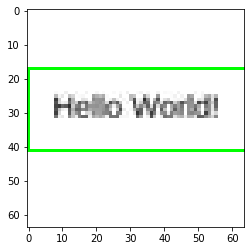

In [21]:
im2 = img.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
     
    # Drawing a rectangle on copied image
    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 1)
     
    # Cropping the text block for giving input to OCR
    cropped = im2[y:y + h, x:x + w]
     
    # Open the file in append mode
    #file = open("recognized.txt", "a")
     
    # Apply OCR on the cropped image
    #text = pytesseract.image_to_string(cropped)
plt.imshow(im2)

# Model

## Tensorflow Data Preparation

In [22]:
class_names = []
for i in glob.glob(fonts_folder+'/*.ttf'):
  font_name = i.split('/')[-1].split('.')[0]
  class_names.append(font_name)

In [23]:
class_names

['Roboto-Regular',
 'FredokaOne-Regular',
 'PTSerif-Regular',
 'Dancing+Script-Regular',
 'Oswald-Regular',
 'PatuaOne-Regular',
 'Arimo-Regular',
 'NotoSans-Regular',
 'Open+Sans-Regular',
 'Ubuntu-Regular']

In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/ImagesDir', labels='inferred', label_mode='int',
    class_names=class_names, color_mode='grayscale', batch_size=32, image_size=(64,
    64), shuffle=True, seed=100, validation_split=0.2,subset='training',
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 500 files belonging to 10 classes.
Using 400 files for training.


In [25]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/ImagesDir', labels='inferred', label_mode='int',
    class_names=class_names, color_mode='grayscale', batch_size=32, image_size=(64,
    64), shuffle=True, seed=100, validation_split=0.2,subset='validation',
)

Found 500 files belonging to 10 classes.
Using 100 files for validation.


In [26]:
class_names = train_ds.class_names
print(class_names)

['Roboto-Regular', 'FredokaOne-Regular', 'PTSerif-Regular', 'Dancing+Script-Regular', 'Oswald-Regular', 'PatuaOne-Regular', 'Arimo-Regular', 'NotoSans-Regular', 'Open+Sans-Regular', 'Ubuntu-Regular']


In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Tensorflow Model Building

In [28]:
import datetime

In [29]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [30]:
img_width,img_height = 64,64

In [31]:
data_augmentation = tf.keras.Sequential(
  [
    #tf.keras.layers.RandomFlip("vertical",input_shape=(img_height,img_width,1)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.GaussianNoise(3),
  ]
)

### Custom Model

In [153]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-5)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [154]:
model = tf.keras.Sequential([ tf.keras.layers.Input((64,64,1)),
                              #data_augmentation,
                              tf.keras.layers.Rescaling(1./255,),

                              tf.keras.layers.Conv2D(64, (8,8), activation='relu',),
                              tf.keras.layers.MaxPooling2D(2, 2),

                              tf.keras.layers.Conv2D(128, (4,4), activation='relu'),
                              tf.keras.layers.MaxPooling2D(2,2),

                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(1024, activation='relu'),
                              tf.keras.layers.Dropout(0.2),
                              # 512 neuron hidden layer
                              tf.keras.layers.Dense(512, activation='relu'),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.Dense(10)
                              ])

In [155]:
model.load_weights('model.h5')

In [156]:
for i in range(0,4):
  model.layers[i].trainable = False

In [157]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [158]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 64, 64, 1)         0         
                                                                 
 conv2d_39 (Conv2D)          (None, 57, 57, 64)        4160      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 25, 25, 128)       131200    
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 18432)           

In [159]:
epochs=200
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32,
  callbacks = [reduce_lr,early_stopping]
)

Epoch 1/200
13/13 [==============================] - 1s 35ms/step - loss: 0.1704 - accuracy: 0.9200 - val_loss: 0.1182 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 0s 21ms/step - loss: 0.0901 - accuracy: 0.9750 - val_loss: 0.0548 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 0s 20ms/step - loss: 0.0730 - accuracy: 0.9800 - val_loss: 0.0356 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 0s 19ms/step - loss: 0.0544 - accuracy: 0.9825 - val_loss: 0.0333 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 0s 19ms/step - loss: 0.0526 - accuracy: 0.9975 - val_loss: 0.0388 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 0s 18ms/step - loss: 0.0551 - accuracy: 0.9900 - val_loss: 0.0260 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 0s 19ms/step - lo

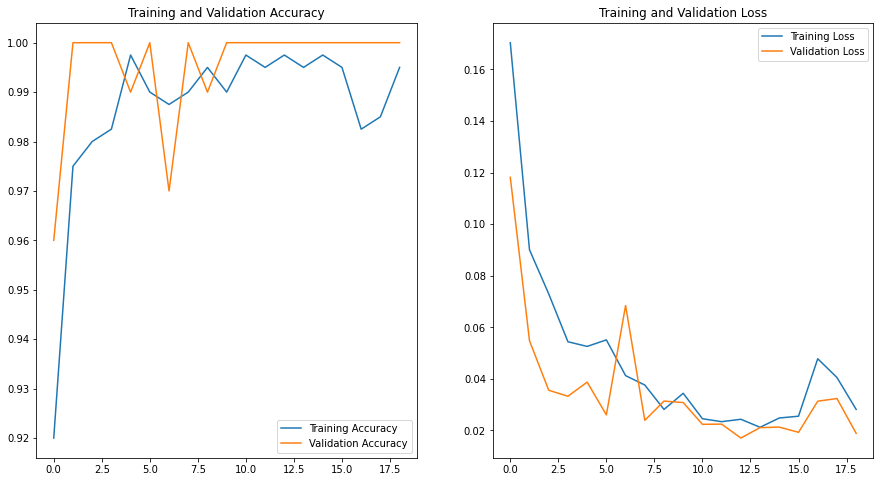

In [161]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [162]:
model.save('working_model.h5')

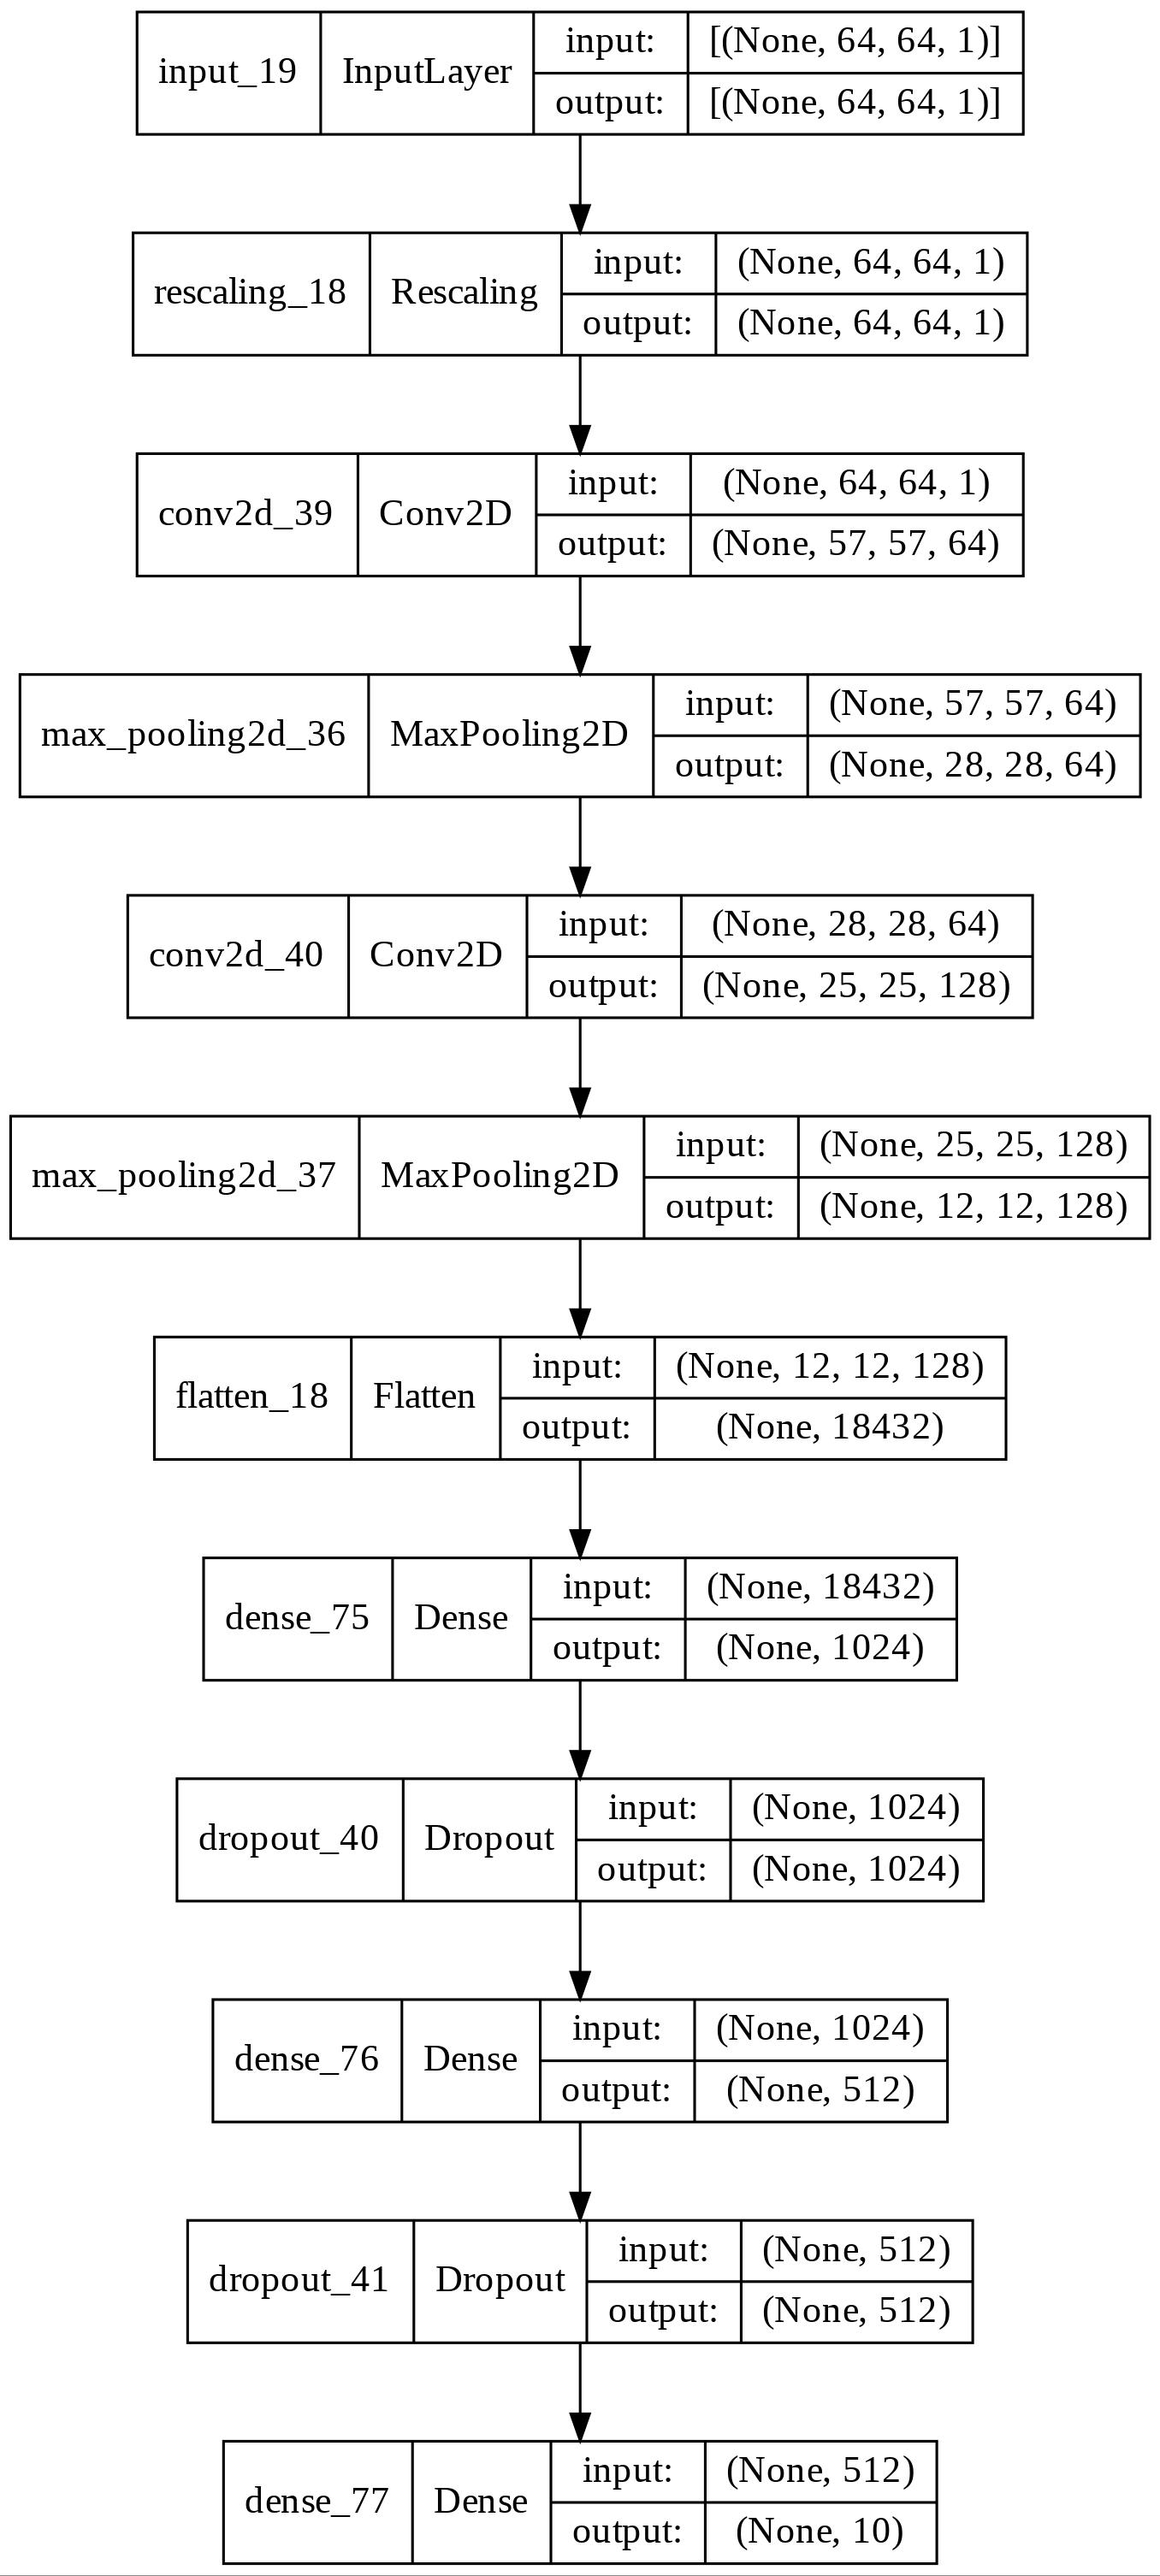

In [164]:
tf.keras.utils.plot_model(model,show_shapes=True,to_file='model_diagram.jpg',dpi=224)